# CDAE

- [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](https://alicezheng.org/papers/wsdm16-cdae.pdf)

## Experiment

- K-fold 사용

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 1s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
def preprocessing(df: pd.DataFrame, threshold = 3.5) -> pd.DataFrame:
    df = df[df.rating > threshold]
    more_than_4 = df.groupby('userId')['movieId'].nunique()
    more_than_4 = more_than_4.index[more_than_4 > 4]
    df = df[df.userId.isin(more_than_4)]
    return df.reset_index(drop = True)

In [5]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [10]:
def make_interaction(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

def data_split(df: pd.DataFrame, test_size = 0.2) -> pd.DataFrame:
    train, test = train_test_split(df, test_size = test_size, stratify = df.userId, random_state = 7777)
    train, test = map(lambda df: df.reset_index(drop = True), (train, test))
    return train, test

In [11]:
def make_generator(df: pd.DataFrame,
                   n_item: int,
                   batch_size: int,
                   implicit = False,
                   threshold = 3.5,
                   user_specific = True,
                   corruption = 0.4,
                   negative_sampling = 5) -> Tuple[np.array, Tuple[np.array, np.array]]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                NS = len(pos) * negative_sampling
                neg = np.random.choice(np.delete(np.arange(n_col), pos), NS)
                p = np.random.uniform(0, 1, size = pos.shape)
                corrupt = pos[p < corruption]

                batch[i, pos] = rating[idx]
                batch[i, corrupt] = 0
                batch[i, neg] = np.finfo(float).eps
            
            if user_specific:
                yield (batch, batch_Id), batch
            else:
                yield batch, batch

In [12]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = tf.cast(tf.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)
   
def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    ce = y_true * K.log(y_pred + K.epsilon()) + (1 - y_true) * K.log(1 - y_pred + K.epsilon())
    masked_ce = mask_true * ce
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

In [13]:
def CDAE(n_user: int,
         n_item: int,
         latent_dim = 50,
         activation = 'linear',
         optimizer = 'adam',
         learning_rate = 0.001,
         kernel_initializer = None,
         kernel_regularizer = None,
         user_specific = True) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)

    if user_specific:
        users = u = Input(shape = (1, ), dtype = 'int32', name = 'user')
        u = Embedding(input_dim = n_user, output_dim = latent_dim, input_length = 1, embeddings_regularizer = kernel_regularizer)(u)
        u = Flatten()(u)
        x = concatenate([x, u], axis = 1)
    
    outputs = Dense(n_item, activation = 'sigmoid', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)
    if user_specific:
        model = Model(inputs = [inputs, users], outputs = outputs)
    else:
        model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = masked_cross_entropy, metrics = [masked_cross_entropy, masked_rmse])
    return model

In [14]:
def make_predictor(df: pd.DataFrame,
                   models: list, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 3.5,
                   user_specific = True,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = np.zeros(shape = (batch_Id.size, n_col))
        if user_specific:
            for model in models:
                y_pred += model.predict([y_true, batch_Id], verbose = 0)
        else:
            for model in models:
                y_pred += model.predict(y_true, verbose = 0)
        y_pred /= len(models)
        pred = np.argsort(np.where(y_true == 1, 0, 1) * y_pred, axis = -1)[:, :-top_N-1:-1]
        res.append(pred)
    return np.concatenate(res)

In [15]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_metric', 'val_masked_metric'], loc = 'upper right')
    plt.show()

In [16]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    for i, r in enumerate(rec):
        idcg += 1.0 / np.log(i + 2)
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

## 2. DAE

In [17]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = False)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 512)               1897984   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1901178   
Total params: 3,799,162
Trainable params: 3,799,162
Non-trainable params: 0
_________________________________________________________________


In [18]:
train, test = data_split(ratings)
train, test = map(make_interaction, (train, test))

In [19]:
epochs = 100
batch_size = 128

n_splits = 5
folds = KFold(n_splits = n_splits, shuffle = True, random_state = 7777)

Start learning 0-th fold...
Epoch 1/100
38/38 [==============================] - 2s 48ms/step - loss: 1.1489 - masked_cross_entropy: 0.4606 - masked_rmse: 0.3700 - val_loss: 0.7878 - val_masked_cross_entropy: 0.3245 - val_masked_rmse: 0.2954
Epoch 2/100
38/38 [==============================] - 2s 43ms/step - loss: 0.6313 - masked_cross_entropy: 0.3087 - masked_rmse: 0.2896 - val_loss: 0.5061 - val_masked_cross_entropy: 0.2941 - val_masked_rmse: 0.2825
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 0.4397 - masked_cross_entropy: 0.2787 - masked_rmse: 0.2750 - val_loss: 0.3893 - val_masked_cross_entropy: 0.2669 - val_masked_rmse: 0.2691
Epoch 4/100
38/38 [==============================] - 2s 47ms/step - loss: 0.3593 - masked_cross_entropy: 0.2566 - masked_rmse: 0.2638 - val_loss: 0.3384 - val_masked_cross_entropy: 0.2520 - val_masked_rmse: 0.2611
Epoch 5/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3220 - masked_cross_entropy: 0.2447 - ma

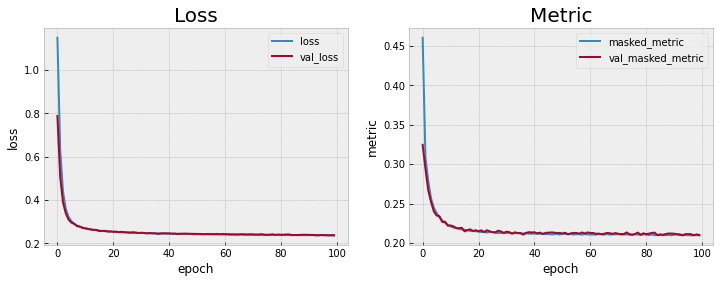

Start learning 1-th fold...
Epoch 1/100
38/38 [==============================] - 2s 47ms/step - loss: 1.1501 - masked_cross_entropy: 0.4624 - masked_rmse: 0.3716 - val_loss: 0.7848 - val_masked_cross_entropy: 0.3221 - val_masked_rmse: 0.2945
Epoch 2/100
38/38 [==============================] - 2s 41ms/step - loss: 0.6302 - masked_cross_entropy: 0.3078 - masked_rmse: 0.2891 - val_loss: 0.5045 - val_masked_cross_entropy: 0.2920 - val_masked_rmse: 0.2815
Epoch 3/100
38/38 [==============================] - 2s 43ms/step - loss: 0.4396 - masked_cross_entropy: 0.2781 - masked_rmse: 0.2750 - val_loss: 0.3840 - val_masked_cross_entropy: 0.2617 - val_masked_rmse: 0.2665
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3588 - masked_cross_entropy: 0.2561 - masked_rmse: 0.2637 - val_loss: 0.3388 - val_masked_cross_entropy: 0.2526 - val_masked_rmse: 0.2618
Epoch 5/100
38/38 [==============================] - 2s 44ms/step - loss: 0.3221 - masked_cross_entropy: 0.2447 - ma

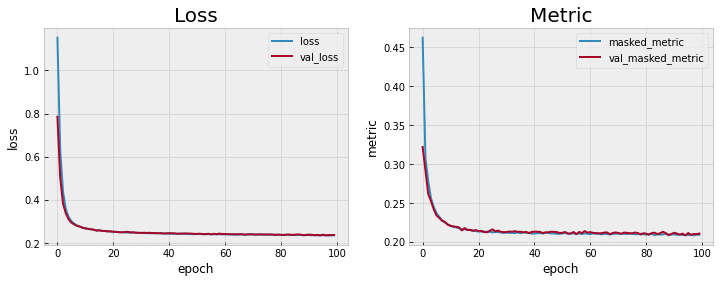

Start learning 2-th fold...
Epoch 1/100
38/38 [==============================] - 2s 47ms/step - loss: 1.1501 - masked_cross_entropy: 0.4619 - masked_rmse: 0.3715 - val_loss: 0.7932 - val_masked_cross_entropy: 0.3302 - val_masked_rmse: 0.2957
Epoch 2/100
38/38 [==============================] - 2s 42ms/step - loss: 0.6297 - masked_cross_entropy: 0.3077 - masked_rmse: 0.2891 - val_loss: 0.5122 - val_masked_cross_entropy: 0.3007 - val_masked_rmse: 0.2836
Epoch 3/100
38/38 [==============================] - 2s 43ms/step - loss: 0.4389 - masked_cross_entropy: 0.2784 - masked_rmse: 0.2745 - val_loss: 0.3898 - val_masked_cross_entropy: 0.2677 - val_masked_rmse: 0.2693
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3581 - masked_cross_entropy: 0.2556 - masked_rmse: 0.2632 - val_loss: 0.3410 - val_masked_cross_entropy: 0.2546 - val_masked_rmse: 0.2618
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3207 - masked_cross_entropy: 0.2434 - ma

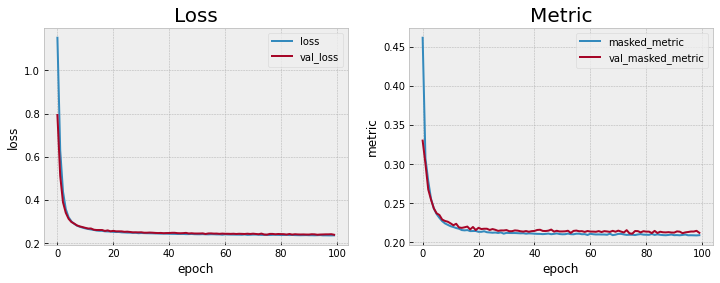

Start learning 3-th fold...
Epoch 1/100
38/38 [==============================] - 2s 46ms/step - loss: 1.1522 - masked_cross_entropy: 0.4637 - masked_rmse: 0.3721 - val_loss: 0.7836 - val_masked_cross_entropy: 0.3208 - val_masked_rmse: 0.2946
Epoch 2/100
38/38 [==============================] - 2s 41ms/step - loss: 0.6324 - masked_cross_entropy: 0.3100 - masked_rmse: 0.2901 - val_loss: 0.5038 - val_masked_cross_entropy: 0.2919 - val_masked_rmse: 0.2823
Epoch 3/100
38/38 [==============================] - 2s 43ms/step - loss: 0.4400 - masked_cross_entropy: 0.2788 - masked_rmse: 0.2745 - val_loss: 0.3855 - val_masked_cross_entropy: 0.2632 - val_masked_rmse: 0.2680
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3585 - masked_cross_entropy: 0.2556 - masked_rmse: 0.2633 - val_loss: 0.3363 - val_masked_cross_entropy: 0.2499 - val_masked_rmse: 0.2613
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3221 - masked_cross_entropy: 0.2449 - ma

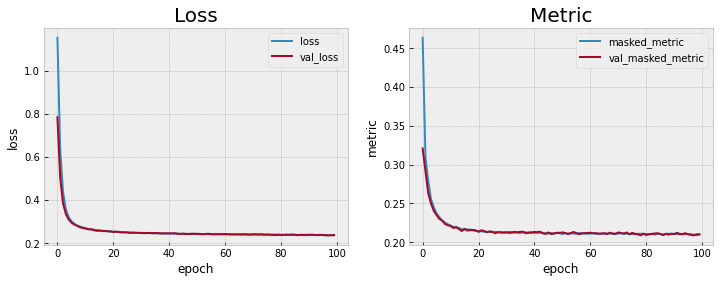

Start learning 4-th fold...
Epoch 1/100
38/38 [==============================] - 2s 47ms/step - loss: 1.1510 - masked_cross_entropy: 0.4608 - masked_rmse: 0.3703 - val_loss: 0.7903 - val_masked_cross_entropy: 0.3260 - val_masked_rmse: 0.2974
Epoch 2/100
38/38 [==============================] - 2s 40ms/step - loss: 0.6314 - masked_cross_entropy: 0.3078 - masked_rmse: 0.2894 - val_loss: 0.5120 - val_masked_cross_entropy: 0.2992 - val_masked_rmse: 0.2857
Epoch 3/100
38/38 [==============================] - 2s 41ms/step - loss: 0.4399 - masked_cross_entropy: 0.2778 - masked_rmse: 0.2746 - val_loss: 0.3925 - val_masked_cross_entropy: 0.2695 - val_masked_rmse: 0.2703
Epoch 4/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3588 - masked_cross_entropy: 0.2553 - masked_rmse: 0.2630 - val_loss: 0.3408 - val_masked_cross_entropy: 0.2540 - val_masked_rmse: 0.2619
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3219 - masked_cross_entropy: 0.2443 - ma

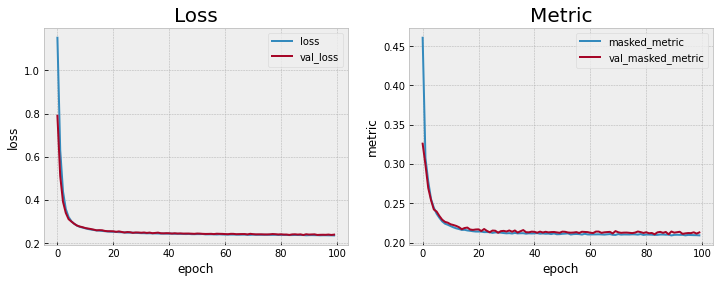

In [20]:
total_hist = []
for i, (train_idx, valid_idx) in enumerate(folds.split(train)):
    print(f'Start learning {i}-th fold...')
    train_f, valid_f = train.iloc[train_idx], train.iloc[valid_idx]
    train_f, valid_f = map(lambda df: df.reset_index(drop = True), (train_f, valid_f))
    train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train_f, valid_f))
    steps_per_epoch = train_f.index.size // batch_size + 1
    validation_steps = valid_f.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = False)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'DAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'masked_cross_entropy')
    total_hist.append(hist)

In [21]:
print('The average of masked_cross_entropy:', np.mean([h.history['val_masked_cross_entropy'][-1] for h in total_hist]))

The average of masked_cross_entropy: 0.2112527906894684


In [22]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(n_splits)]

pred = make_predictor(train, models, n_item, batch_size, user_specific = False)
pred

array([[  26,  124,   40, ...,  105,  390,  547],
       [  23,   92,  167, ...,  264,  244,  156],
       [ 124,   22,   13, ...,   97,  189,  116],
       ...,
       [ 104,  134,   23, ...,  116,  127,  171],
       [ 719,  766, 1195, ...,  633,  600,  743],
       [ 559,  321, 1240, ..., 1120, 1545,  355]])

In [25]:
def evaluator(true: pd.DataFrame, pred):
    m_ndcg = 0
    m_recall = 0
    m_precision = 0
    map_k = 0
    for i in range(len(pred)):
        rec = pred[i]
        gt = true.at[i, 'movieId']
        m_ndcg += ndcg(gt, rec)
        m_recall += recall(gt, rec)
        m_precision += precision(gt, rec)
        map_k += AP_k(gt, rec)
    m_ndcg /= len(pred)
    m_recall /= len(pred)
    m_precision /= len(pred)
    map_k /= len(pred)
    return m_ndcg, m_recall, m_precision, map_k

In [27]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.20423 
Recall: 0.22836 
Precision: 0.17376 
MAP: 0.15033


## 3. CDAE

In [28]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = True)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 512)       3092480     user[0][0]                       
__________________________________________________________________________________________________
encoder (Dense)                 (None, 512)          1897984     input[0][0]                      
______________________________________________________________________________________

In [29]:
train, test = data_split(ratings)
train, test = map(make_interaction, (train, test))

In [31]:
epochs = 100
batch_size = 128

n_splits = 5
folds = KFold(n_splits = n_splits, shuffle = True, random_state = 7777)

Start learning 0-th fold...
Epoch 1/100
38/38 [==============================] - 2s 54ms/step - loss: 1.1536 - masked_cross_entropy: 0.4640 - masked_rmse: 0.3718 - val_loss: 0.7913 - val_masked_cross_entropy: 0.3263 - val_masked_rmse: 0.2962
Epoch 2/100
38/38 [==============================] - 2s 44ms/step - loss: 0.6321 - masked_cross_entropy: 0.3078 - masked_rmse: 0.2889 - val_loss: 0.5072 - val_masked_cross_entropy: 0.2943 - val_masked_rmse: 0.2833
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 0.4400 - masked_cross_entropy: 0.2777 - masked_rmse: 0.2742 - val_loss: 0.3907 - val_masked_cross_entropy: 0.2672 - val_masked_rmse: 0.2692
Epoch 4/100
38/38 [==============================] - 2s 48ms/step - loss: 0.3590 - masked_cross_entropy: 0.2556 - masked_rmse: 0.2633 - val_loss: 0.3355 - val_masked_cross_entropy: 0.2486 - val_masked_rmse: 0.2598
Epoch 5/100
38/38 [==============================] - 2s 50ms/step - loss: 0.3222 - masked_cross_entropy: 0.2444 - ma

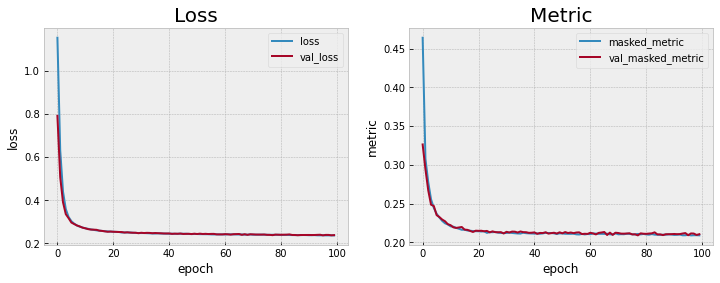

Start learning 1-th fold...
Epoch 1/100
38/38 [==============================] - 2s 48ms/step - loss: 1.1534 - masked_cross_entropy: 0.4652 - masked_rmse: 0.3729 - val_loss: 0.7845 - val_masked_cross_entropy: 0.3227 - val_masked_rmse: 0.2960
Epoch 2/100
38/38 [==============================] - 2s 44ms/step - loss: 0.6297 - masked_cross_entropy: 0.3072 - masked_rmse: 0.2889 - val_loss: 0.5032 - val_masked_cross_entropy: 0.2905 - val_masked_rmse: 0.2806
Epoch 3/100
38/38 [==============================] - 2s 45ms/step - loss: 0.4389 - masked_cross_entropy: 0.2775 - masked_rmse: 0.2742 - val_loss: 0.3871 - val_masked_cross_entropy: 0.2640 - val_masked_rmse: 0.2669
Epoch 4/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3585 - masked_cross_entropy: 0.2553 - masked_rmse: 0.2631 - val_loss: 0.3361 - val_masked_cross_entropy: 0.2497 - val_masked_rmse: 0.2607
Epoch 5/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3215 - masked_cross_entropy: 0.2444 - ma

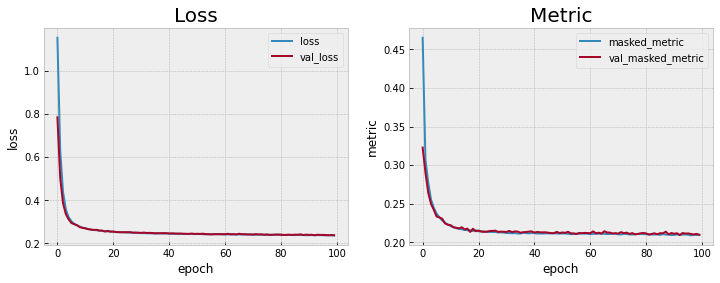

Start learning 2-th fold...
Epoch 1/100
38/38 [==============================] - 2s 47ms/step - loss: 1.1510 - masked_cross_entropy: 0.4609 - masked_rmse: 0.3705 - val_loss: 0.7955 - val_masked_cross_entropy: 0.3309 - val_masked_rmse: 0.2970
Epoch 2/100
38/38 [==============================] - 2s 42ms/step - loss: 0.6304 - masked_cross_entropy: 0.3063 - masked_rmse: 0.2885 - val_loss: 0.5122 - val_masked_cross_entropy: 0.3000 - val_masked_rmse: 0.2850
Epoch 3/100
38/38 [==============================] - 2s 43ms/step - loss: 0.4407 - masked_cross_entropy: 0.2795 - masked_rmse: 0.2753 - val_loss: 0.3905 - val_masked_cross_entropy: 0.2677 - val_masked_rmse: 0.2683
Epoch 4/100
38/38 [==============================] - 2s 44ms/step - loss: 0.3586 - masked_cross_entropy: 0.2557 - masked_rmse: 0.2633 - val_loss: 0.3422 - val_masked_cross_entropy: 0.2556 - val_masked_rmse: 0.2626
Epoch 5/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3216 - masked_cross_entropy: 0.2437 - ma

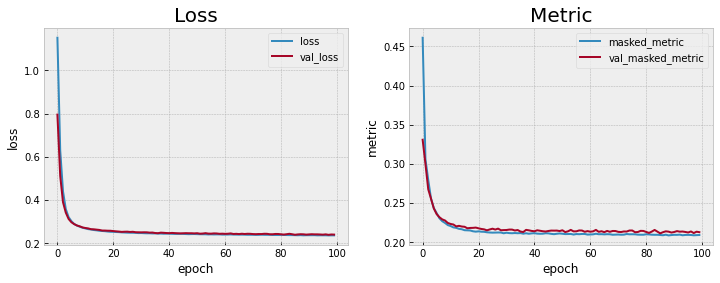

Start learning 3-th fold...
Epoch 1/100
38/38 [==============================] - 2s 48ms/step - loss: 1.1544 - masked_cross_entropy: 0.4664 - masked_rmse: 0.3733 - val_loss: 0.7841 - val_masked_cross_entropy: 0.3212 - val_masked_rmse: 0.2960
Epoch 2/100
38/38 [==============================] - 2s 42ms/step - loss: 0.6315 - masked_cross_entropy: 0.3088 - masked_rmse: 0.2897 - val_loss: 0.5034 - val_masked_cross_entropy: 0.2910 - val_masked_rmse: 0.2818
Epoch 3/100
38/38 [==============================] - 2s 43ms/step - loss: 0.4405 - masked_cross_entropy: 0.2788 - masked_rmse: 0.2749 - val_loss: 0.3851 - val_masked_cross_entropy: 0.2621 - val_masked_rmse: 0.2679
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3598 - masked_cross_entropy: 0.2569 - masked_rmse: 0.2641 - val_loss: 0.3345 - val_masked_cross_entropy: 0.2485 - val_masked_rmse: 0.2603
Epoch 5/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3220 - masked_cross_entropy: 0.2447 - ma

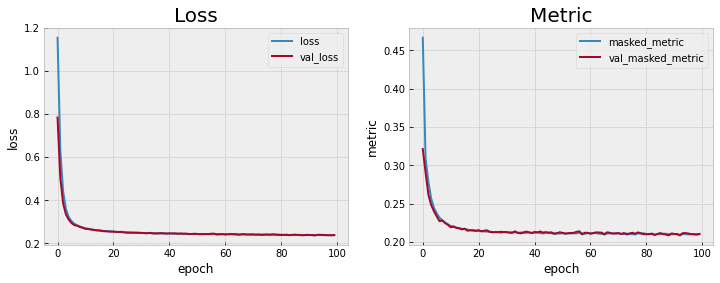

Start learning 4-th fold...
Epoch 1/100
38/38 [==============================] - 2s 52ms/step - loss: 1.1501 - masked_cross_entropy: 0.4603 - masked_rmse: 0.3700 - val_loss: 0.7908 - val_masked_cross_entropy: 0.3258 - val_masked_rmse: 0.2963
Epoch 2/100
38/38 [==============================] - 2s 41ms/step - loss: 0.6305 - masked_cross_entropy: 0.3068 - masked_rmse: 0.2888 - val_loss: 0.5112 - val_masked_cross_entropy: 0.2986 - val_masked_rmse: 0.2847
Epoch 3/100
38/38 [==============================] - 2s 40ms/step - loss: 0.4392 - masked_cross_entropy: 0.2771 - masked_rmse: 0.2743 - val_loss: 0.3940 - val_masked_cross_entropy: 0.2707 - val_masked_rmse: 0.2704
Epoch 4/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3591 - masked_cross_entropy: 0.2563 - masked_rmse: 0.2639 - val_loss: 0.3396 - val_masked_cross_entropy: 0.2531 - val_masked_rmse: 0.2618
Epoch 5/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3211 - masked_cross_entropy: 0.2439 - ma

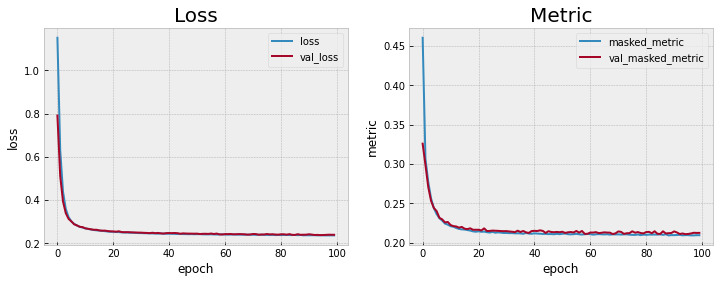

In [32]:
total_hist = []
for i, (train_idx, valid_idx) in enumerate(folds.split(train)):
    print(f'Start learning {i}-th fold...')
    train_f, valid_f = train.iloc[train_idx], train.iloc[valid_idx]
    train_f, valid_f = map(lambda df: df.reset_index(drop = True), (train_f, valid_f))
    train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train_f, valid_f))
    steps_per_epoch = train_f.index.size // batch_size + 1
    validation_steps = valid_f.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = False)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'CDAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'masked_cross_entropy')
    total_hist.append(hist)

In [33]:
print('The average of masked_cross_entropy:', np.mean([h.history['val_masked_cross_entropy'][-1] for h in total_hist]))

The average of masked_cross_entropy: 0.21123265624046325


In [34]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(n_splits)]

pred = make_predictor(train, models, n_item, batch_size, user_specific = False)
pred

array([[  26,  124,   40, ...,  105,  390,  547],
       [  23,   92,  167, ...,  264,  244,  156],
       [ 124,   22,   13, ...,   97,  189,  116],
       ...,
       [ 104,  134,   23, ...,  116,  127,  171],
       [ 719,  766, 1195, ...,  633,  600,  743],
       [ 559,  321, 1240, ..., 1120, 1545,  355]])

In [35]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.20423 
Recall: 0.22836 
Precision: 0.17376 
MAP: 0.15033
